In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


# **Load Dataset**

In [2]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
df.describe(include = "all")

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [6]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

There are 7043 customers in the dataset and there are no missing values

# **EDA**

In [7]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
for i in categorical_features:
    print(i)

customerID
gender
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
TotalCharges
Churn


In [8]:
# Identify numerical features
numerical_features = df.select_dtypes(include=['int64','float64']).columns.tolist()
for i in numerical_features:
    print(i)

SeniorCitizen
tenure
MonthlyCharges


* Most of the featues in the dataset are categorical

In [9]:
for cat in categorical_features:
    print(cat)
    print(df[cat].unique())

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender
['Female' 'Male']
Partner
['Yes' 'No']
Dependents
['No' 'Yes']
PhoneService
['No' 'Yes']
MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
Contract
['Month-to-month' 'One year' 'Two year']
PaperlessBilling
['Yes' 'No']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges
['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn
['No' 'Yes']


We do not need the customer id column for EDA

In [10]:
categorical_features.remove("customerID")

In [11]:
for num in numerical_features:
    print(num)
    print(df[num].unique())

SeniorCitizen
[0 1]
tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
MonthlyCharges
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]


* Have to treat SeniorCitizen as a categorical feature
* Have to treat total charges as a numerical feature

In [12]:
numerical_features.remove("SeniorCitizen")  # treat this as categorical
categorical_features.append("SeniorCitizen")

categorical_features.remove("TotalCharges") #treat this as numerical
numerical_features.append("TotalCharges")


* TotalCharges has to be numerical

In [13]:
# Convert TotalCharges to numeric, forcing errors to NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Check how many became NaN (were blanks)
print("Missing values in TotalCharges:", df["TotalCharges"].isna().sum())

Missing values in TotalCharges: 11


In [14]:
# Find rows where TotalCharges is NaN
missing_total = df[df["TotalCharges"].isna()]

# Show how many and their tenure values
print(missing_total["tenure"].value_counts())

# Quick check
#print(missing_total.head())

tenure
0    11
Name: count, dtype: int64


These are brand new customers and have a 0 totalcharge. We will impute the 0 for Total Charges

In [15]:
# Impute with 0 (new customers with no charges yet)
df["TotalCharges"].fillna(0, inplace=True)

# Verify
print(df["TotalCharges"].dtype)
print(df.loc[df["tenure"] == 0, ["tenure", "TotalCharges"]].head())

float64
      tenure  TotalCharges
488        0           0.0
753        0           0.0
936        0           0.0
1082       0           0.0
1340       0           0.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [17]:
categorical_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'SeniorCitizen']

In [18]:
numerical_features

['tenure', 'MonthlyCharges', 'TotalCharges']

### 👤 Demographic Features
- **gender** – Whether the customer is male or female  
- **SeniorCitizen** – Indicates if the customer is a senior citizen (1 = Yes, 0 = No)  
- **Partner** – Whether the customer has a partner  
- **Dependents** – Whether the customer has dependents  

### 🔧 Behavioral / Services Features
- **PhoneService** – Whether the customer has phone service  
- **MultipleLines** – Whether the customer has multiple lines  
- **InternetService** – Type of internet service (DSL, Fiber optic, None)  
- **OnlineSecurity** – Whether the customer has online security service  
- **OnlineBackup** – Whether the customer has online backup service  
- **DeviceProtection** – Whether the customer has device protection service  
- **TechSupport** – Whether the customer has tech support service  
- **StreamingTV** – Whether the customer has streaming TV service  
- **StreamingMovies** – Whether the customer has streaming movies service  
- **Contract** – Type of contract (Month-to-month, One year, Two year)  
- **PaperlessBilling** – Whether the customer uses paperless billing  

### 💰 Financial Features
- **MonthlyCharges** – Amount charged to the customer monthly  
- **TotalCharges** – Total amount charged to the customer during their tenure  
- **PaymentMethod** – Payment method used by the customer  

### 🎯 Target Variable
- **Churn** – Indicates whether the customer left the company (Yes = churned, No = retained)


# **Churn distribution**

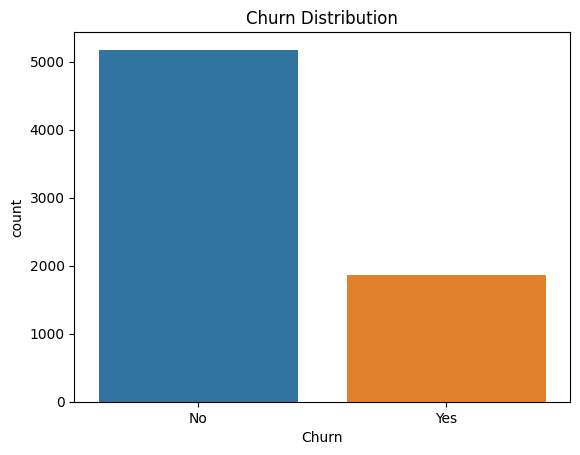

In [19]:
# Target distribution
sns.countplot(data=df, x="Churn")
plt.title("Churn Distribution")
plt.show()

In [20]:
churn_rate = df["Churn"].value_counts(normalize=True)
print("Churn Rate:\n", churn_rate)

Churn Rate:
 Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [21]:
churn_counts = df['Churn'].value_counts()
imbalance_ratio = churn_counts['No'] / churn_counts['Yes']
print("Imbalance Ratio (No:Yes) =", imbalance_ratio)

Imbalance Ratio (No:Yes) = 2.7683253076511503


It seems like there is a huge imbalance in the dataset where the number of not churned customers are high than the number of churned customers

# **Categorical Feature distributions**

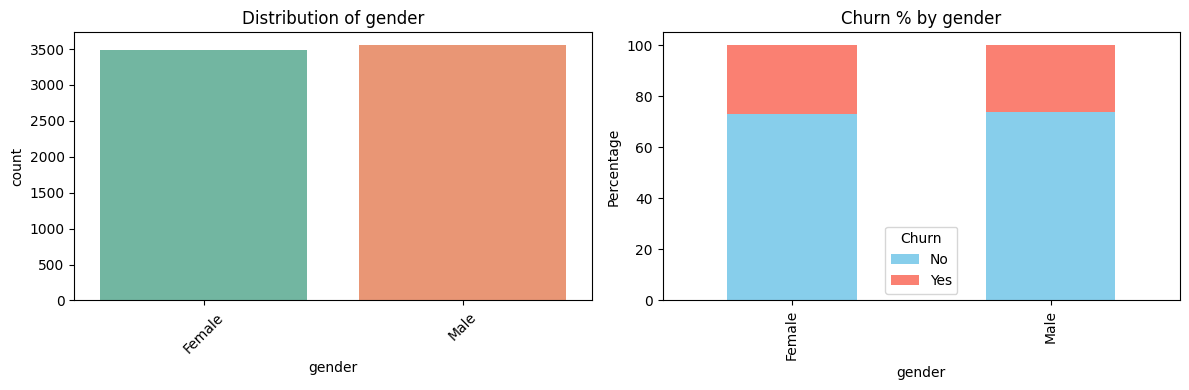

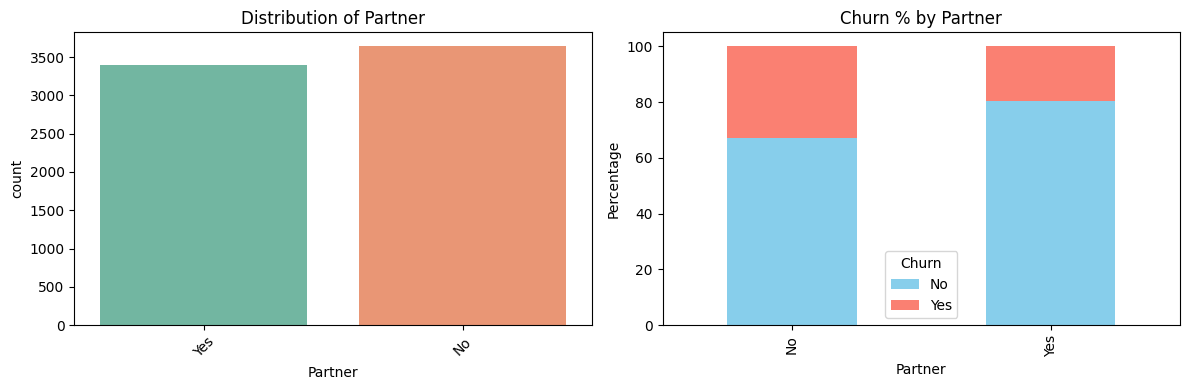

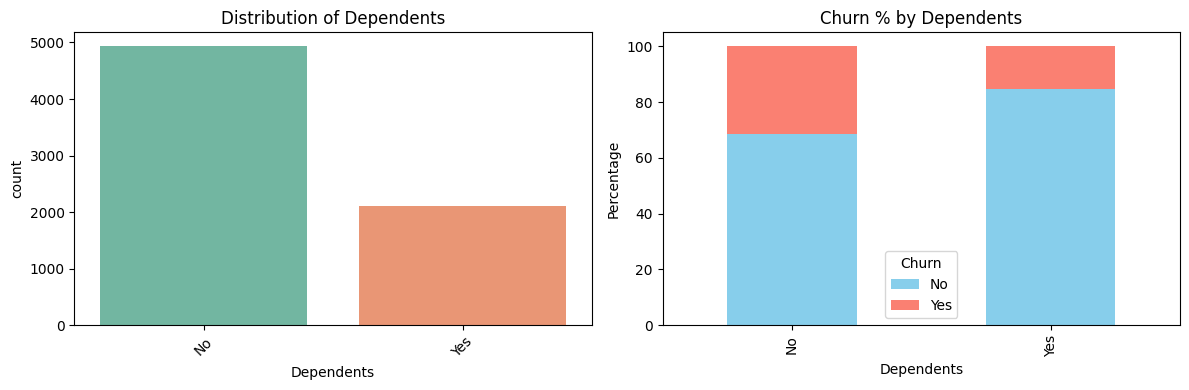

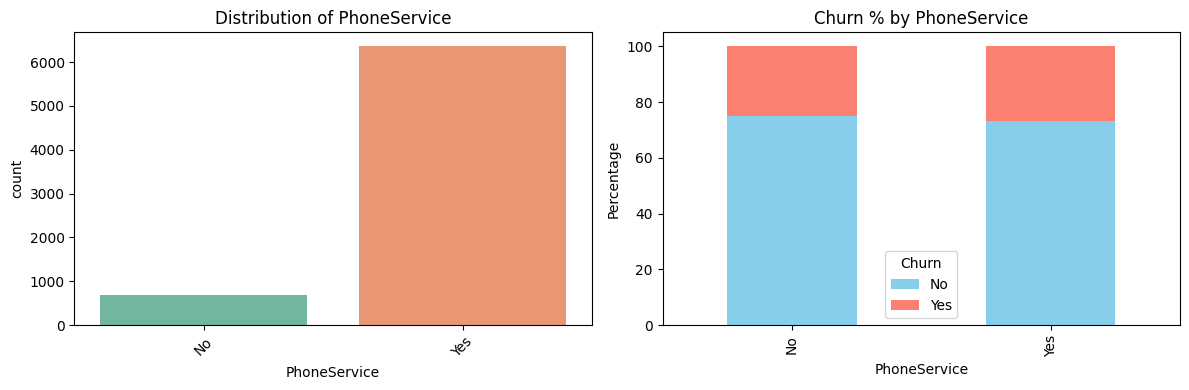

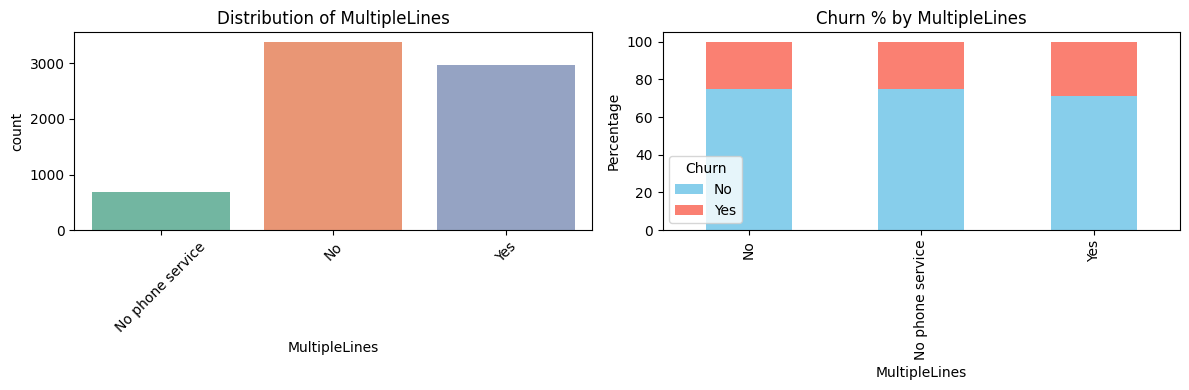

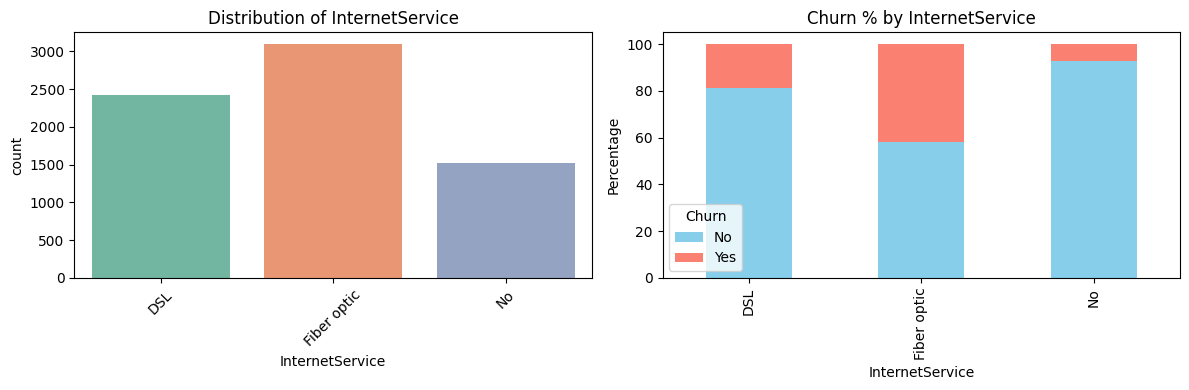

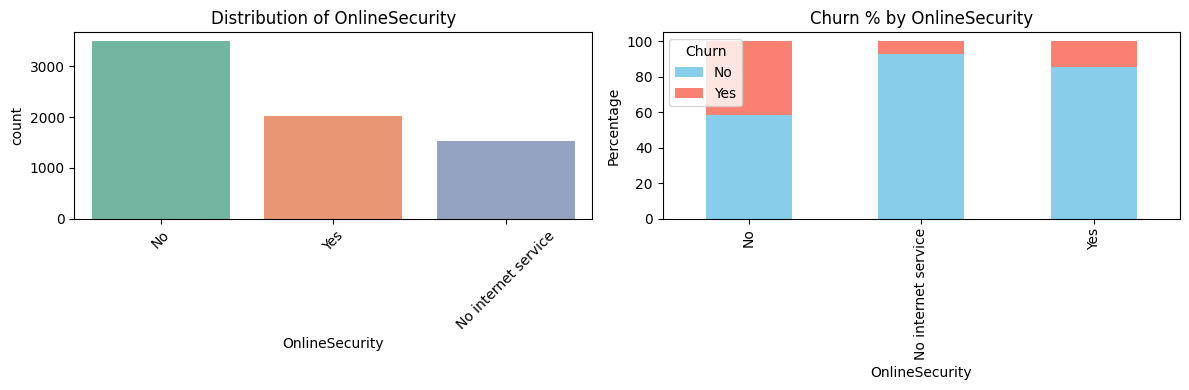

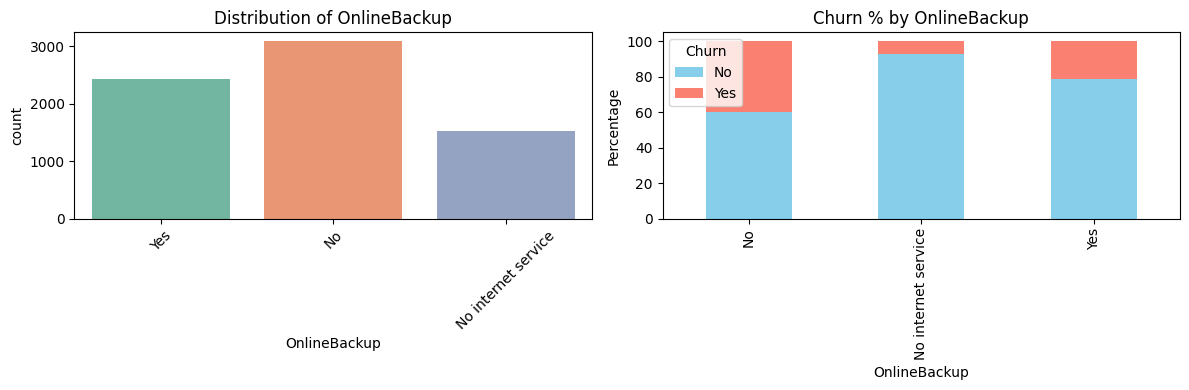

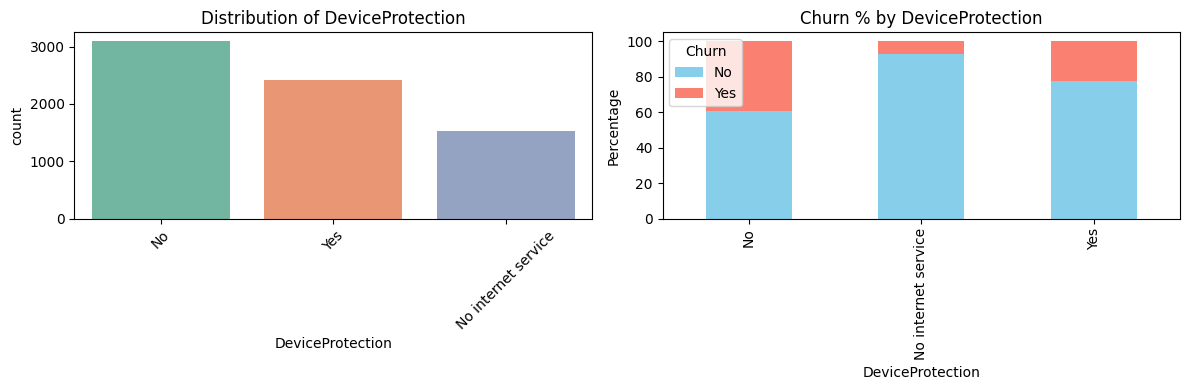

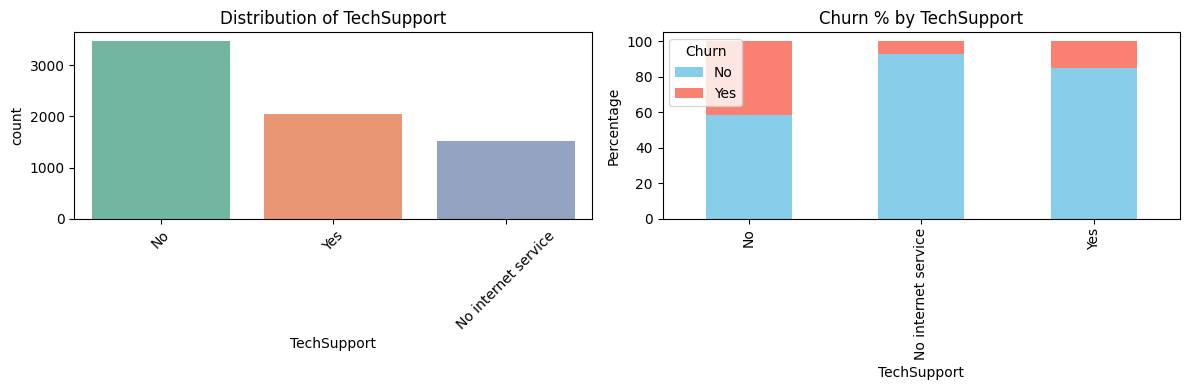

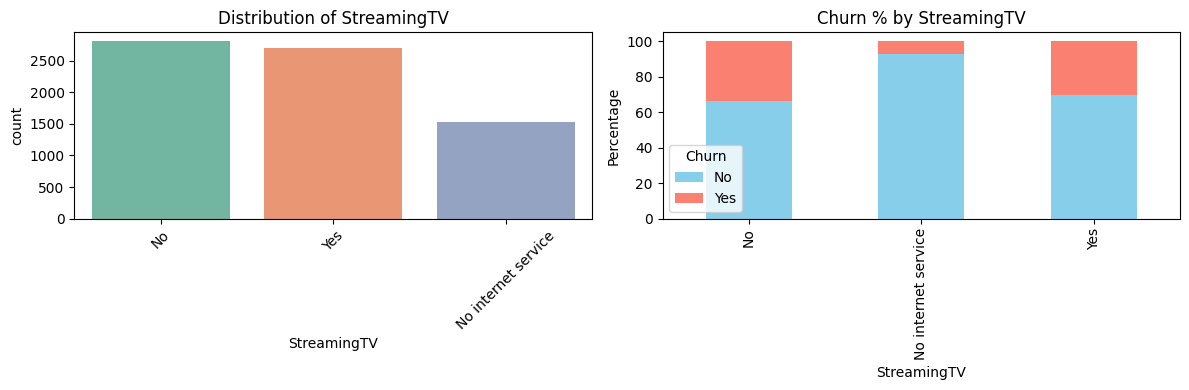

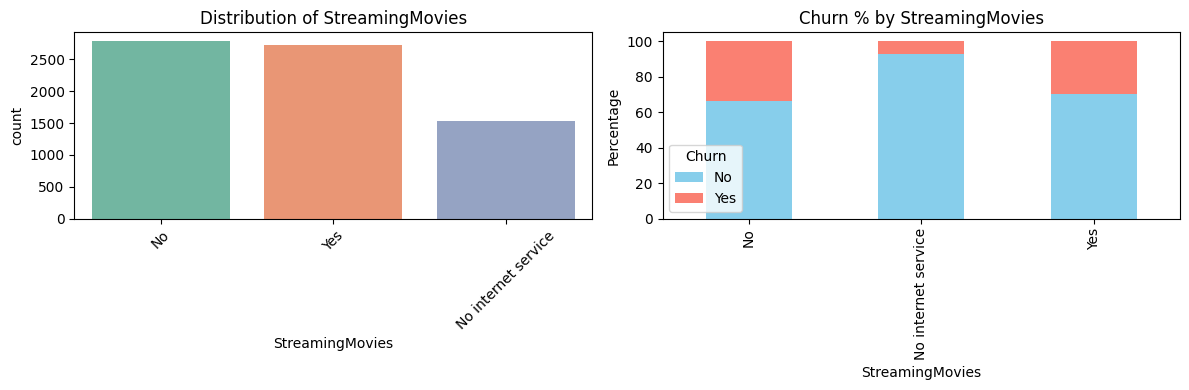

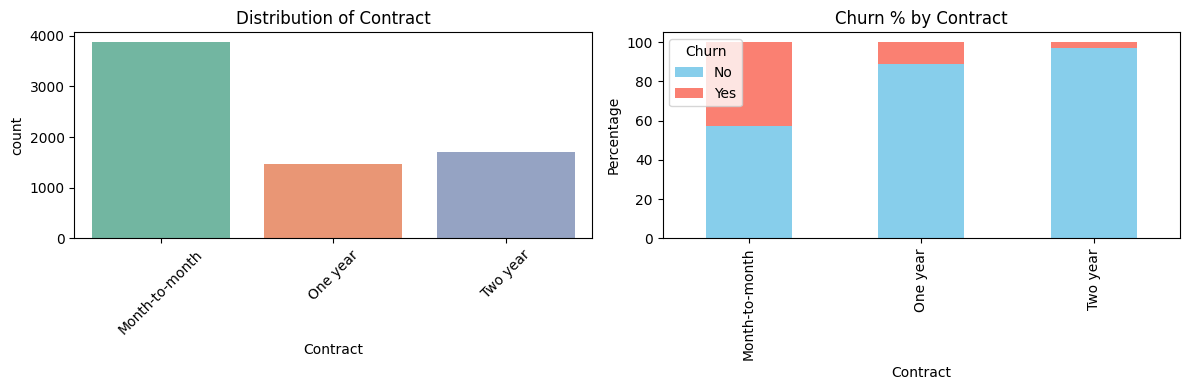

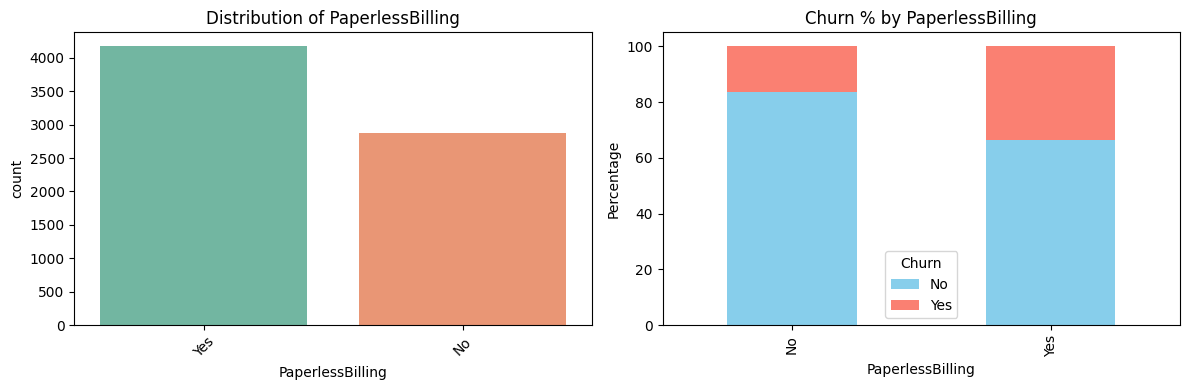

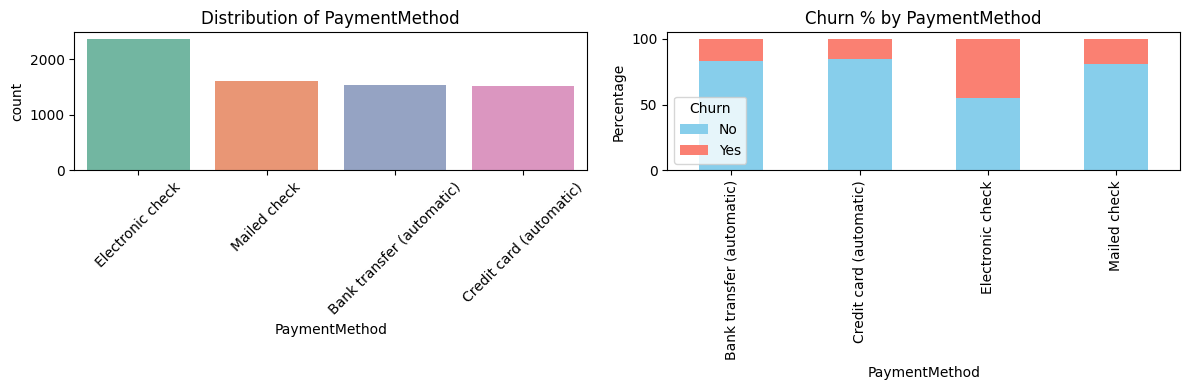

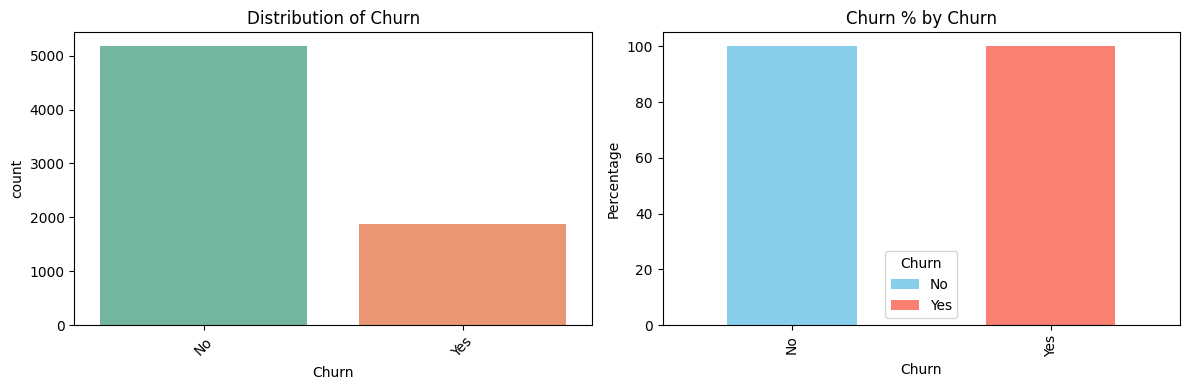

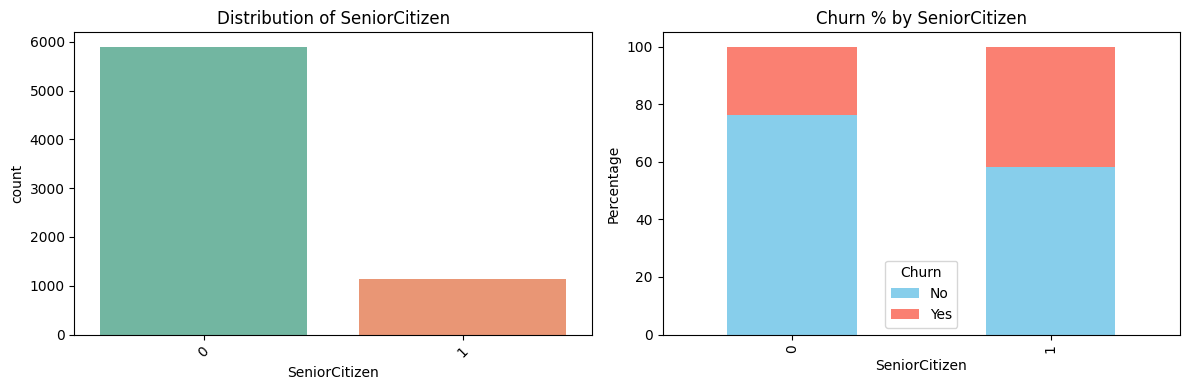

In [22]:
for col in categorical_features:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # Left: Distribution of feature
    sns.countplot(x=col, data=df, ax=axes[0], palette="Set2")
    axes[0].set_title(f"Distribution of {col}")
    axes[0].tick_params(axis='x', rotation=45)

    # Right: Feature vs Churn
    churn_dist = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    churn_dist.plot(kind='bar', stacked=True, color=['skyblue','salmon'], ax=axes[1])
    axes[1].set_title(f"Churn % by {col}")
    axes[1].set_ylabel("Percentage")
    axes[1].legend(title="Churn")

    plt.tight_layout()
    plt.show()


# **Numerical Feature Distributions**

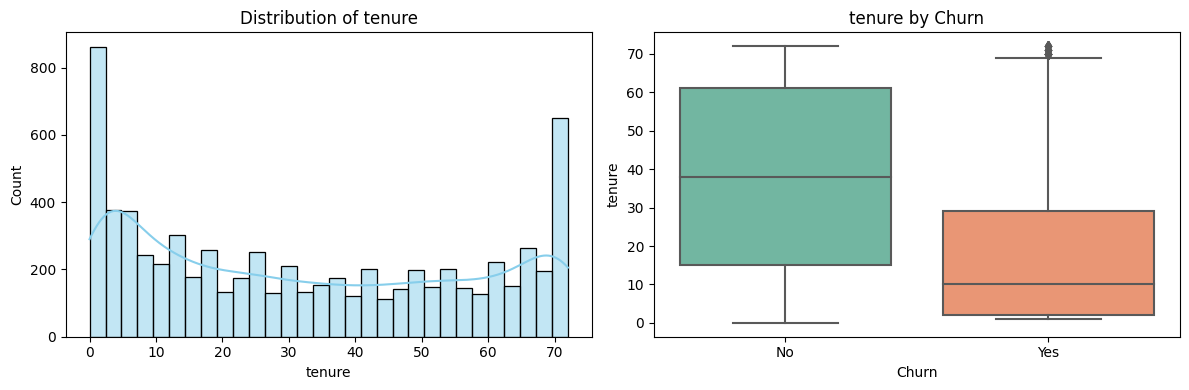

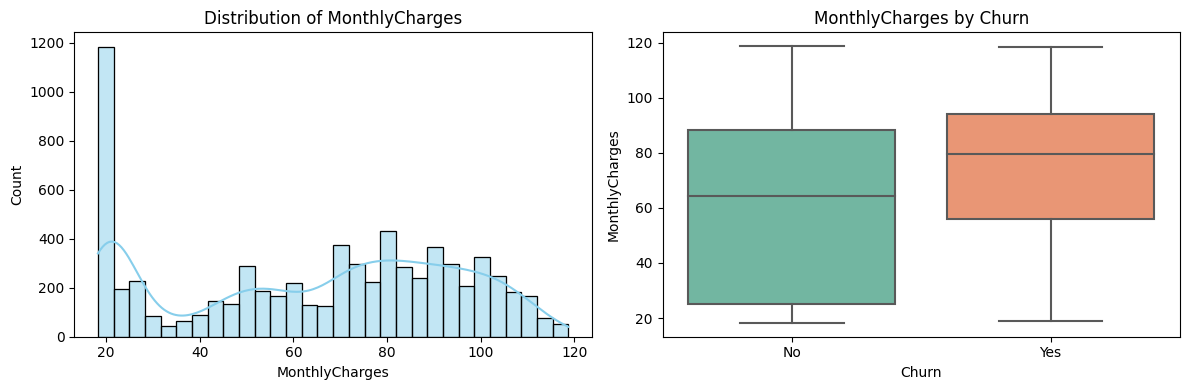

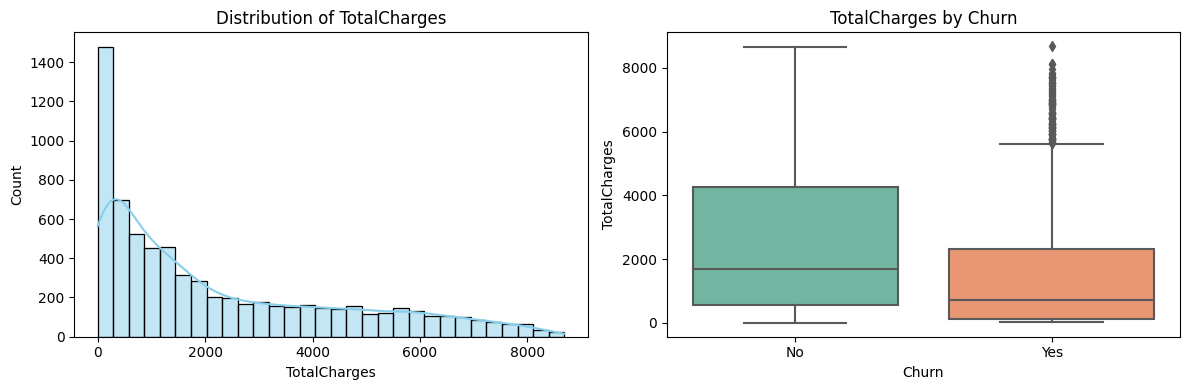

In [23]:
for col in numerical_features:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # Left: Distribution (histogram)
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Distribution of {col}")

    # Right: Boxplot vs Churn
    sns.boxplot(x="Churn", y=col, data=df, palette="Set2", ax=axes[1])
    axes[1].set_title(f"{col} by Churn")

    plt.tight_layout()
    plt.show()

# **Outlier Detection**

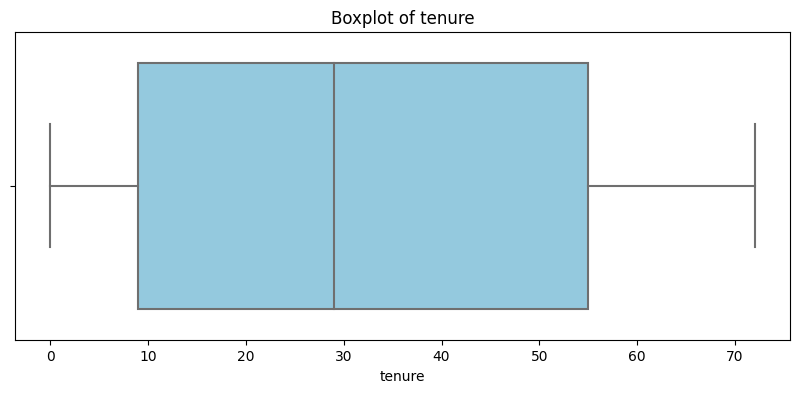

tenure: 0 outliers detected
Lower bound: -60.0, Upper bound: 124.0



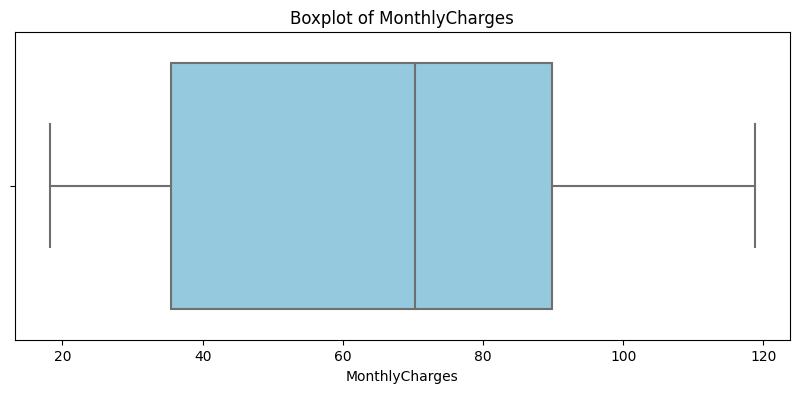

MonthlyCharges: 0 outliers detected
Lower bound: -46.02499999999999, Upper bound: 171.375



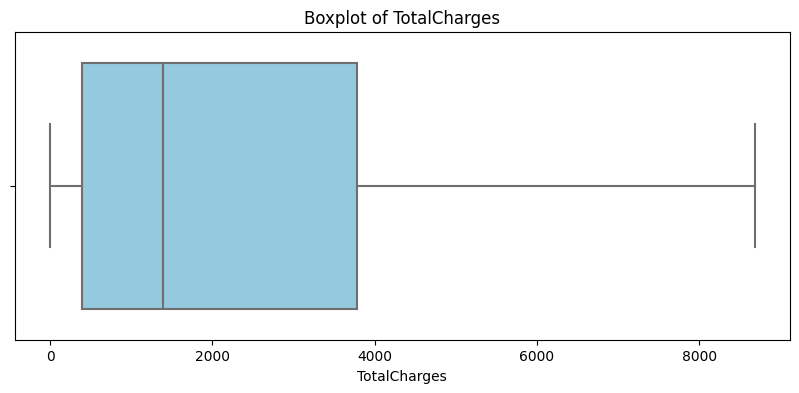

TotalCharges: 0 outliers detected
Lower bound: -4683.525, Upper bound: 8868.675



In [24]:
# ==============================
# OUTLIER DETECTION (Step 2 - EDA)
# ==============================

for col in numerical_features:
    plt.figure(figsize=(10,4))

    # Boxplot
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
    plt.show()

    # IQR Calculation
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {outliers.shape[0]} outliers detected")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}\n")


No outliers detected

# **Feature Engineering**

# Tenture_category

* New: 0-1 year
* Established: 1-4 years
* Loyal: 4-6 years

In [25]:
def tenure_category(tenure):
    if tenure <= 12: 
        return "New"          # 0–1 year
    elif tenure <= 48: 
        return "Established"  # 1–4 years
    else: 
        return "Loyal"        # 4–6 years

df["Tenure_category"] = df["tenure"].apply(tenure_category)

# Charge_category

* The category customer is involved in monthly charges

In [26]:
df["Charge_category"] = pd.qcut(df["MonthlyCharges"], q=3, labels=["Low","Medium","High"])

# Service_count

* Total number of services a customer has

In [27]:
service_cols = ['PhoneService','MultipleLines','InternetService',
                'OnlineSecurity','OnlineBackup','DeviceProtection',
                'TechSupport','StreamingTV','StreamingMovies']

df["Service_count"] = (df[service_cols] == "Yes").sum(axis=1)

# Bundle_user

* Customers with both Internet + Phone

In [28]:
# BundleUser: 1 if customer has BOTH InternetService (not 'No') and PhoneService = 'Yes'
df["Bundle_user"] = np.where(
    (df["InternetService"] != "No") & (df["PhoneService"] == "Yes"), 1, 0
)

# **EDA after feature engineering**

In [29]:
categorical_features.extend(["Charge_category", "Tenure_category","Bundle_user"])
numerical_features.append("Service_count")

**Feature distributions**

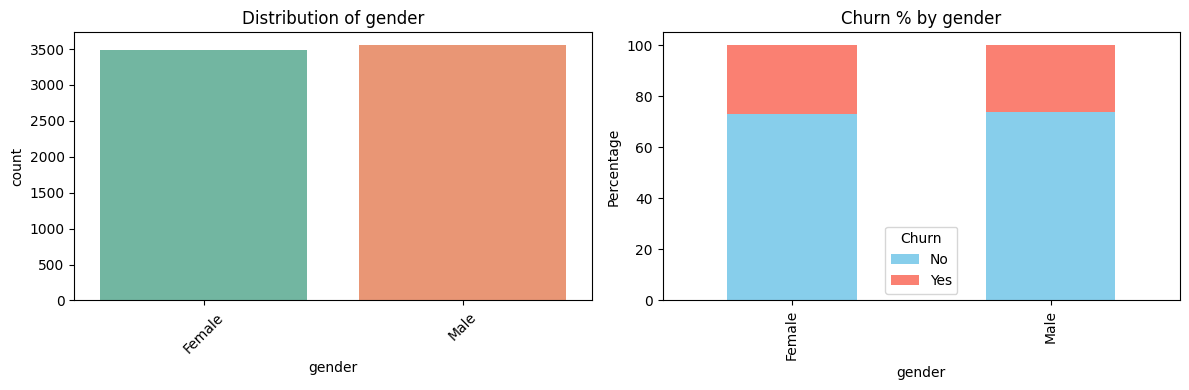

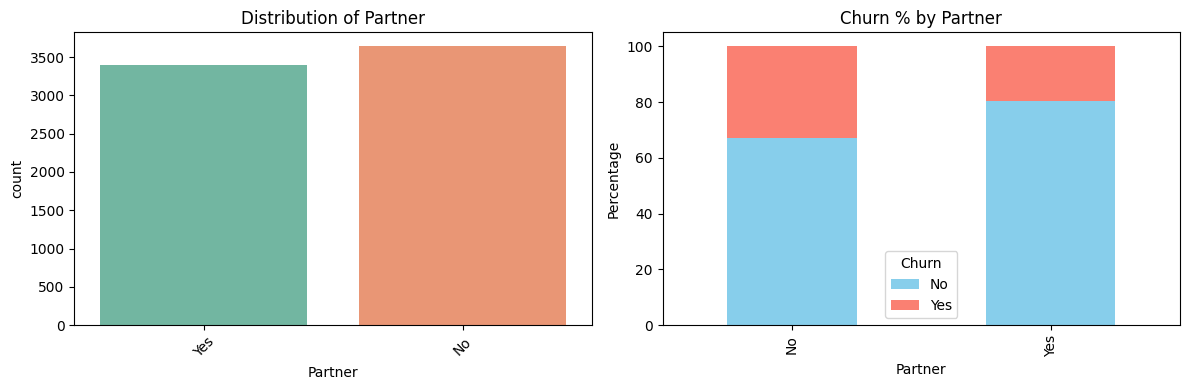

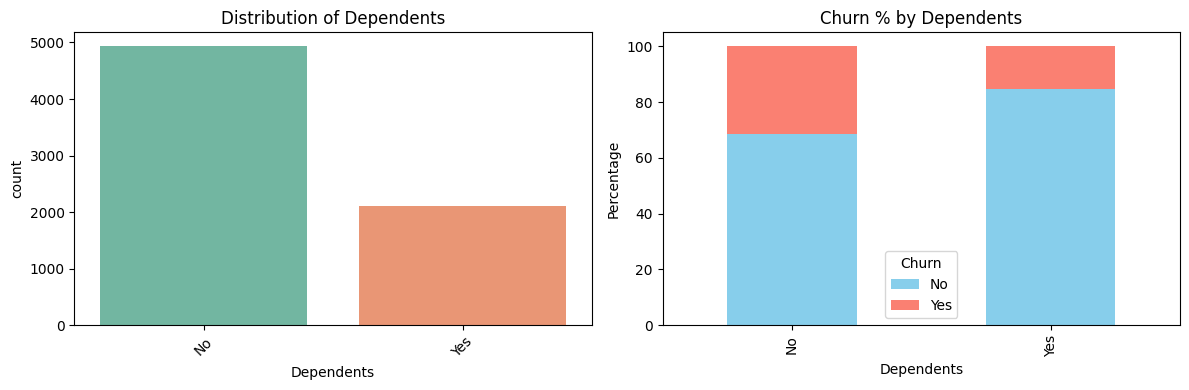

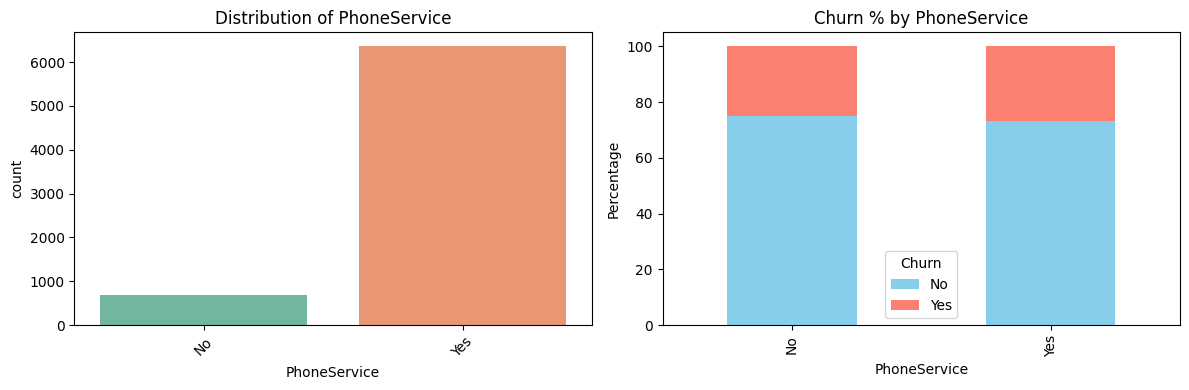

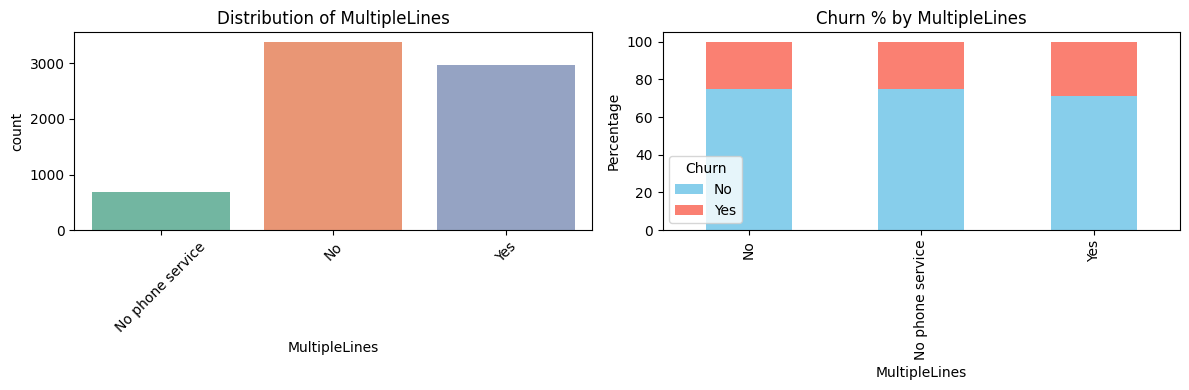

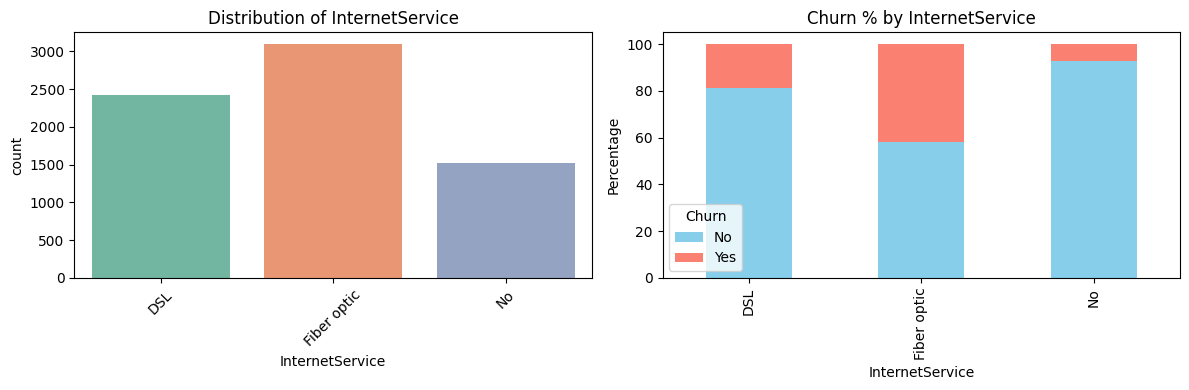

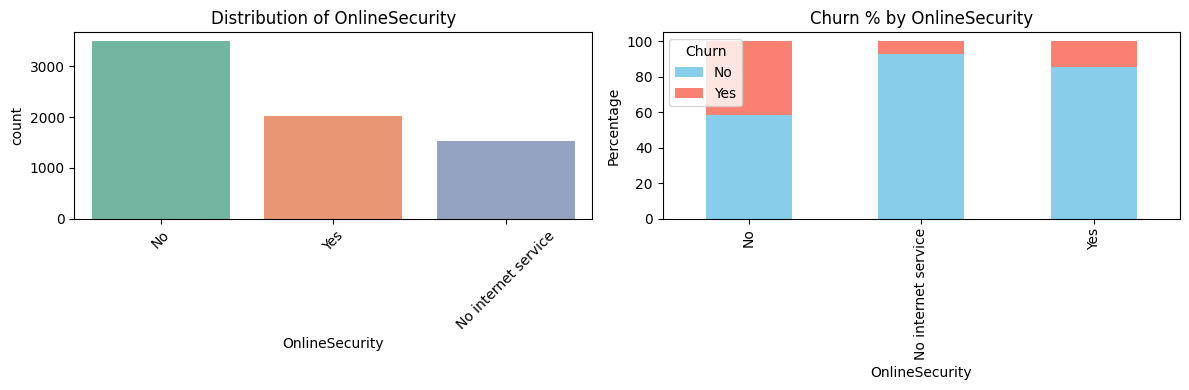

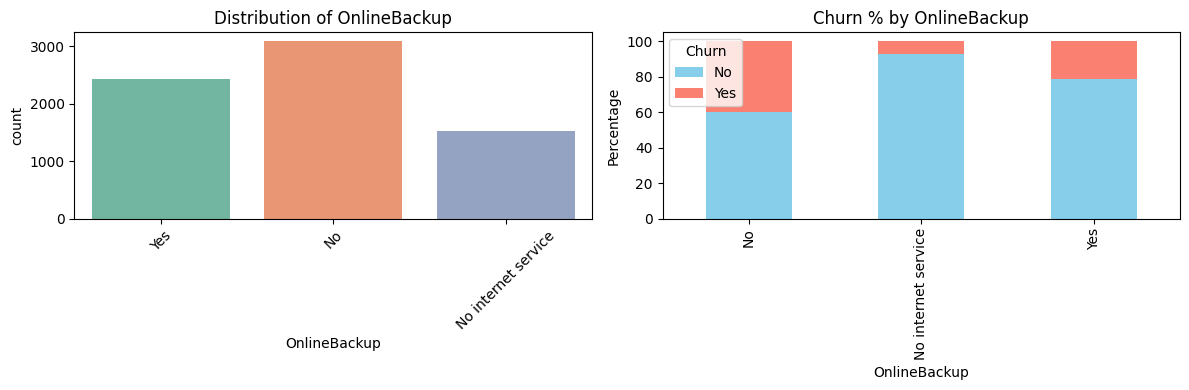

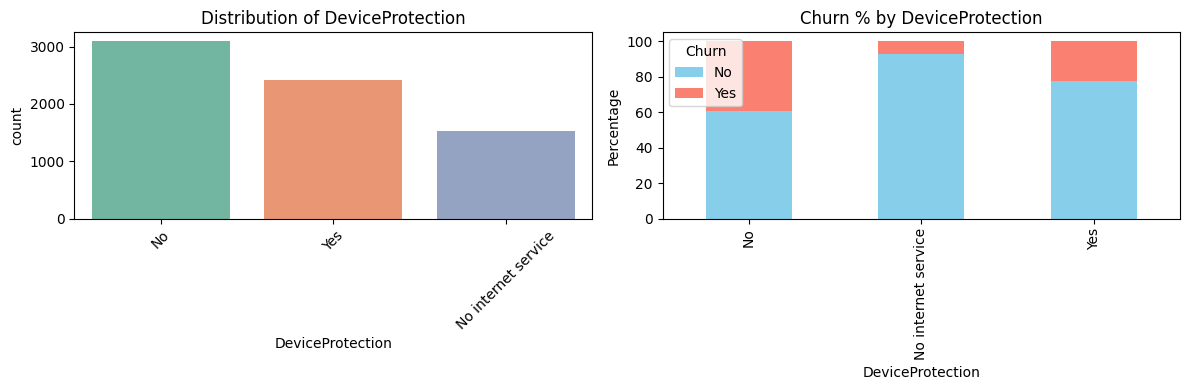

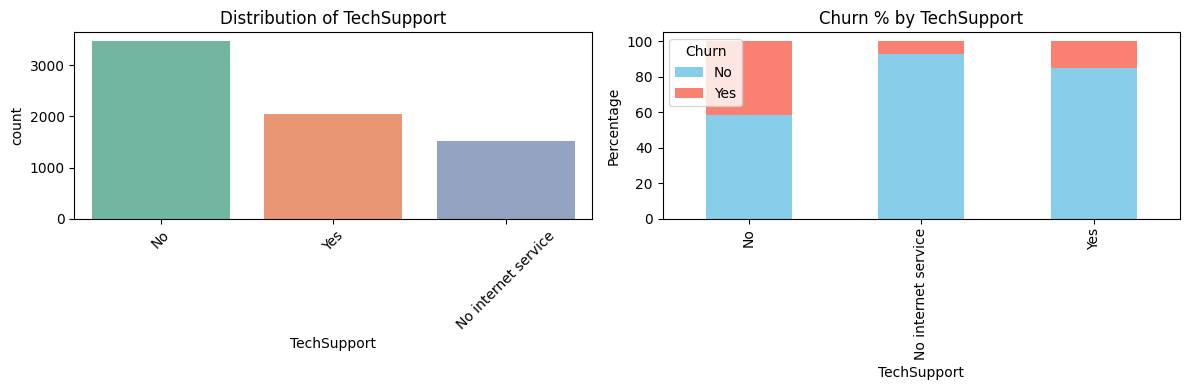

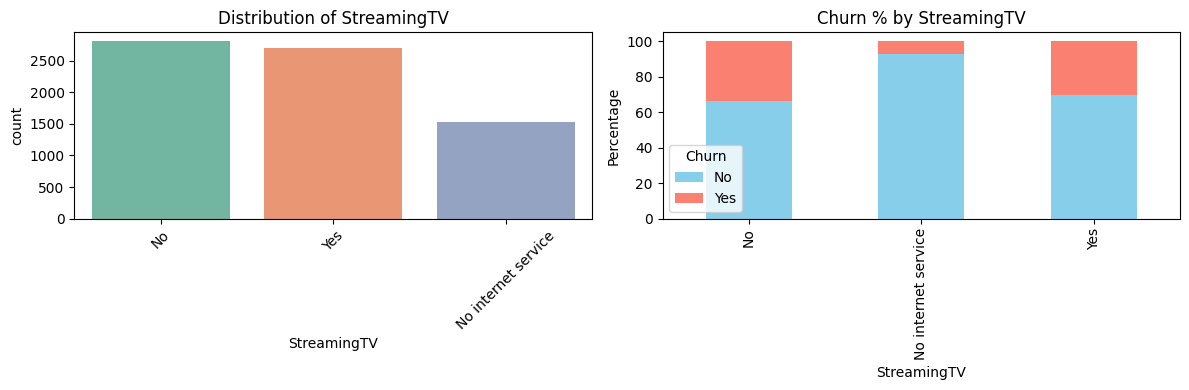

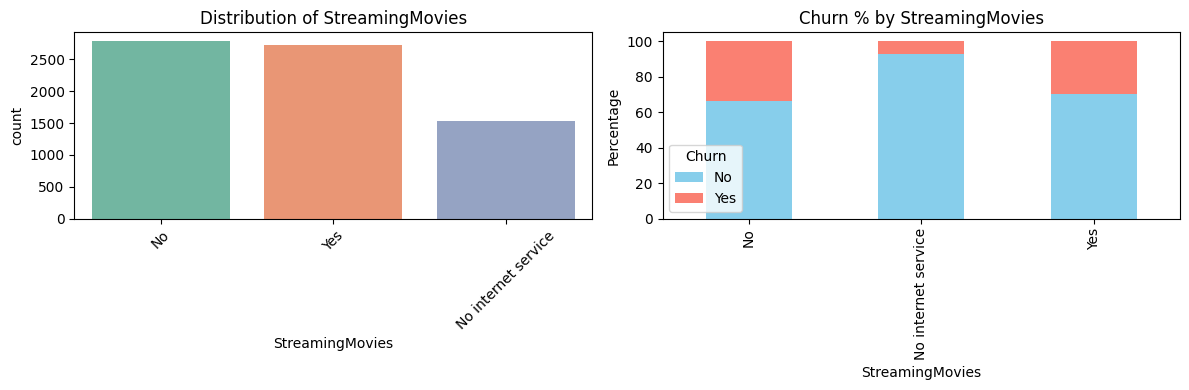

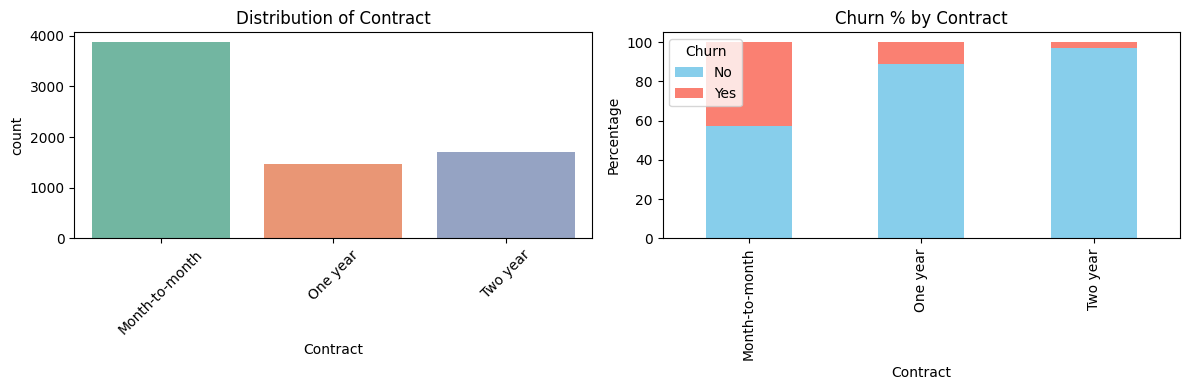

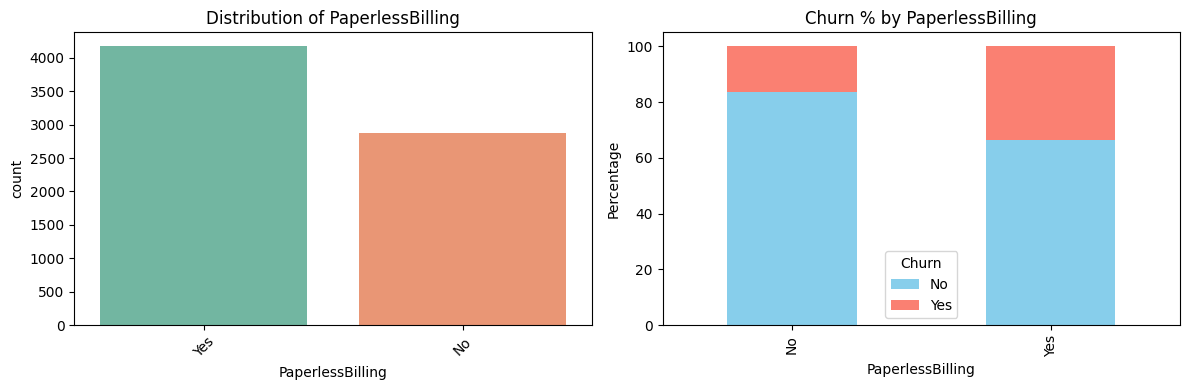

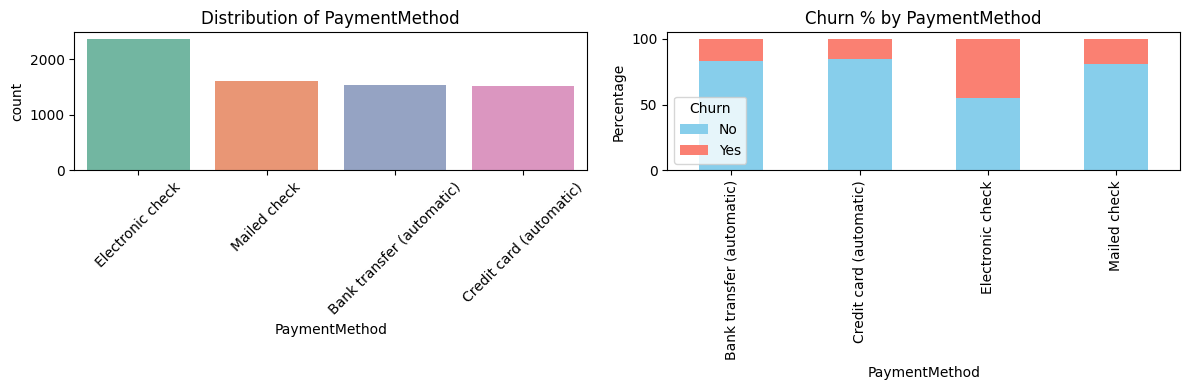

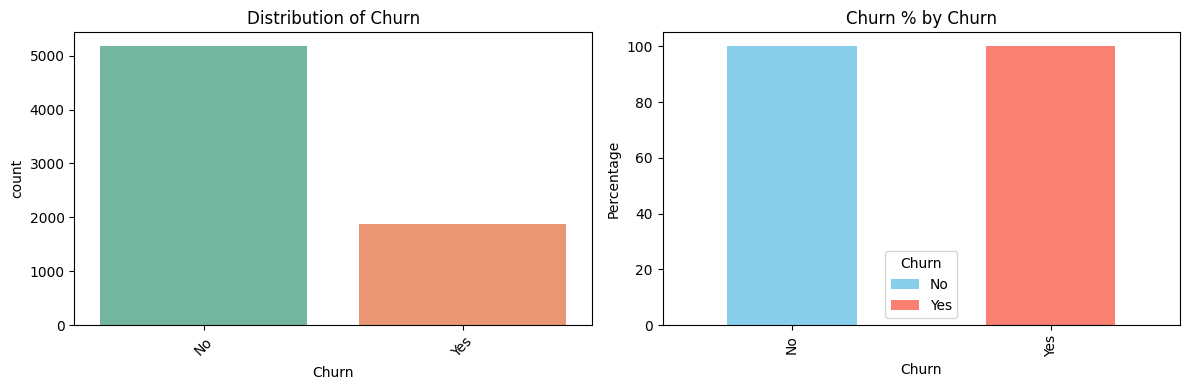

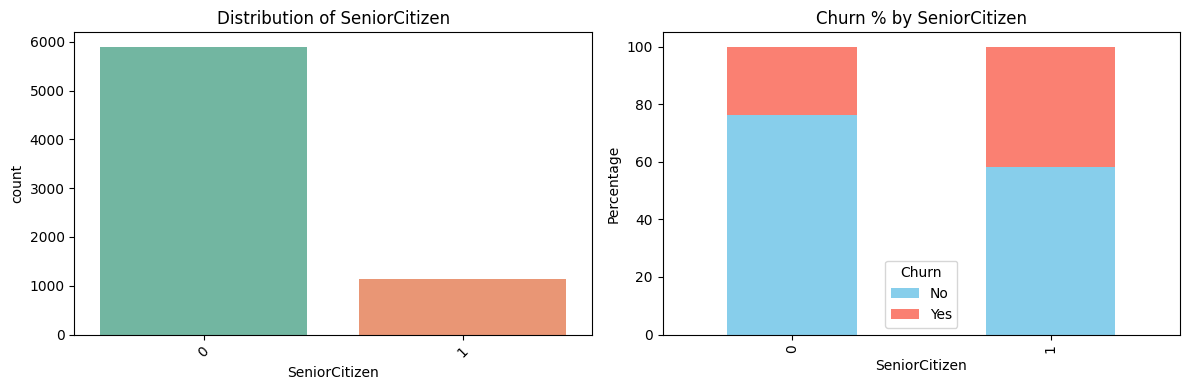

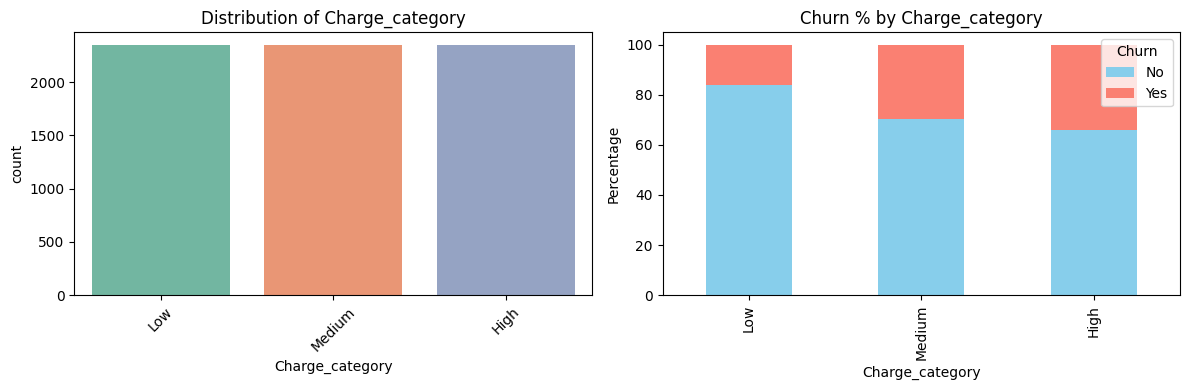

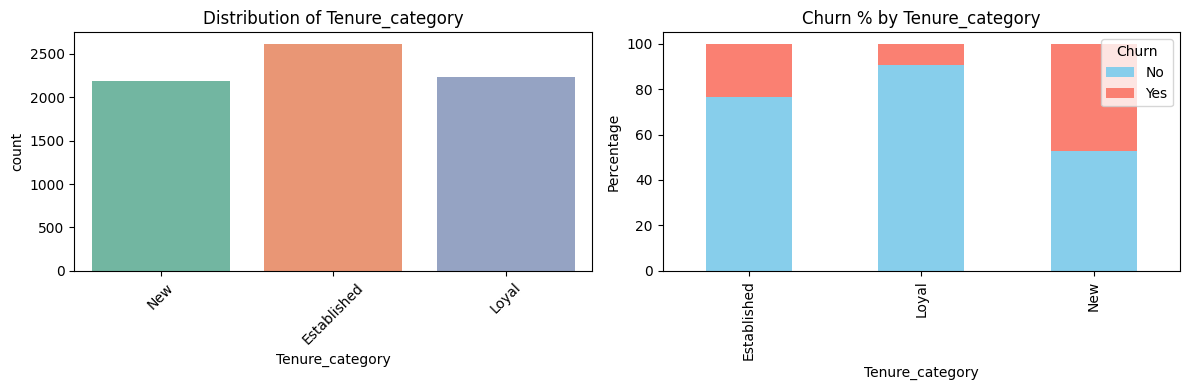

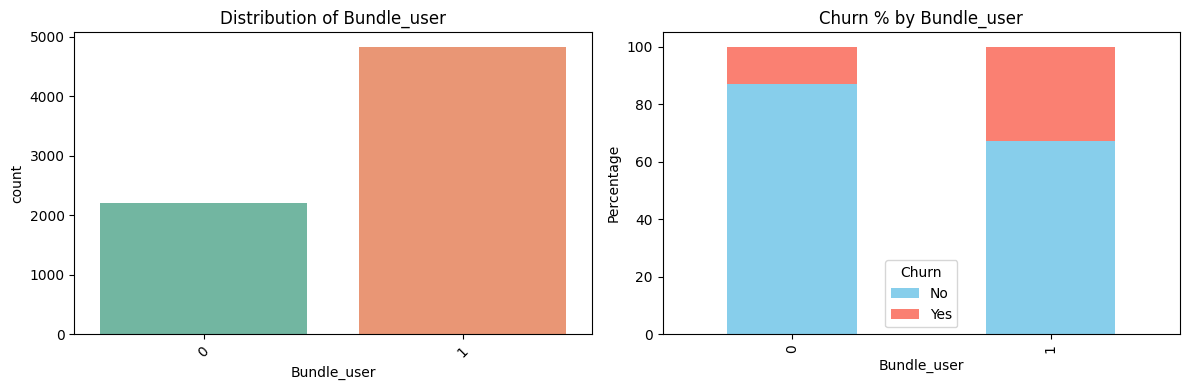

In [30]:
for col in categorical_features:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # Left: Distribution of feature
    sns.countplot(x=col, data=df, ax=axes[0], palette="Set2")
    axes[0].set_title(f"Distribution of {col}")
    axes[0].tick_params(axis='x', rotation=45)

    # Right: Feature vs Churn
    churn_dist = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    churn_dist.plot(kind='bar', stacked=True, color=['skyblue','salmon'], ax=axes[1])
    axes[1].set_title(f"Churn % by {col}")
    axes[1].set_ylabel("Percentage")
    axes[1].legend(title="Churn")

    plt.tight_layout()
    plt.show()

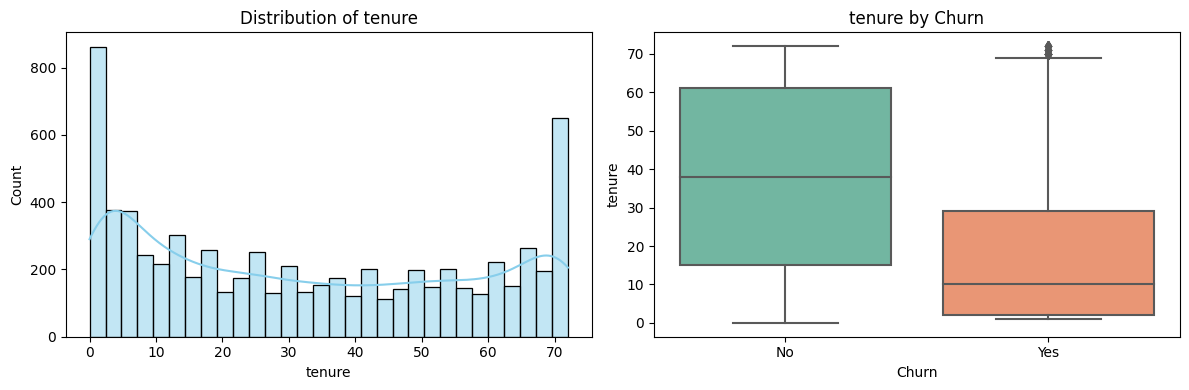

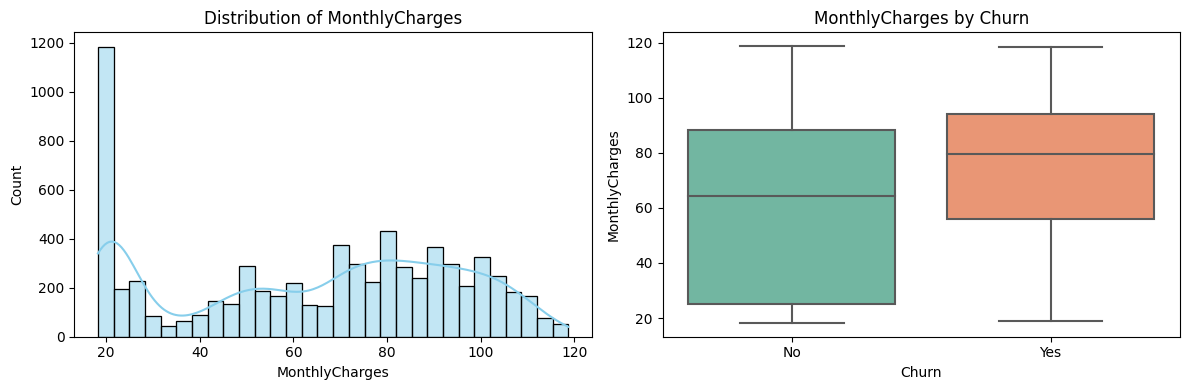

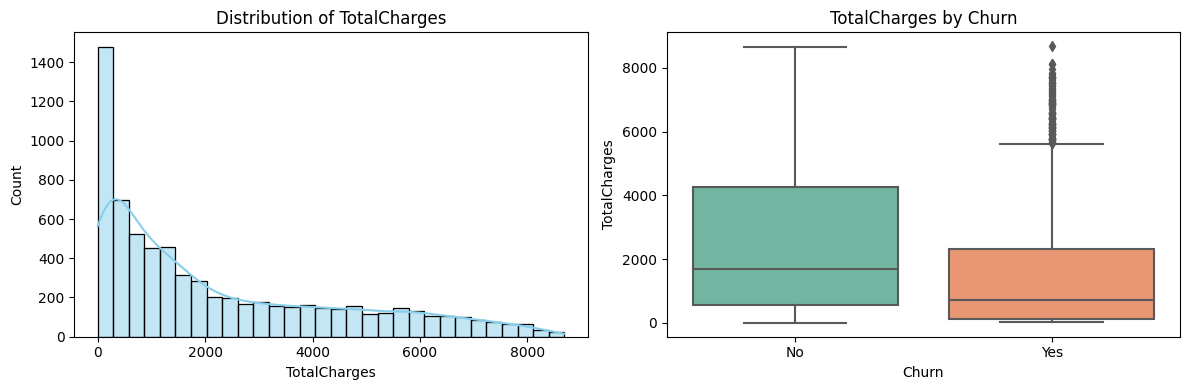

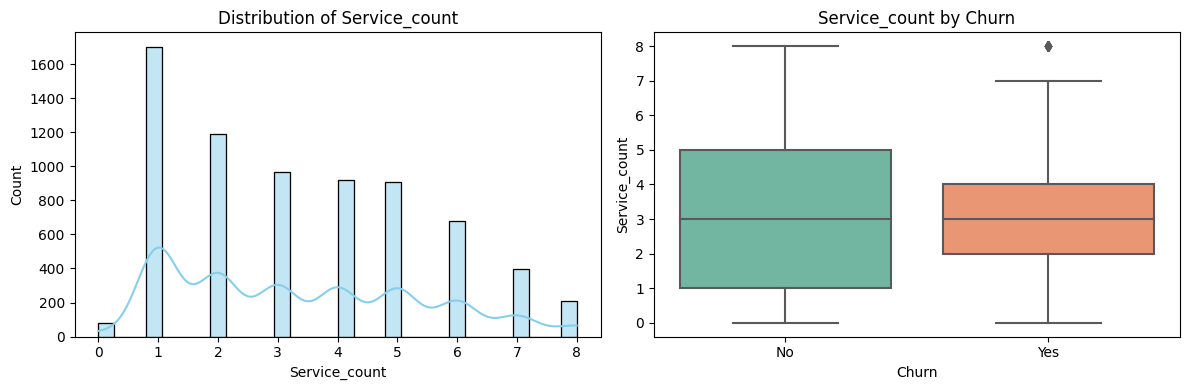

In [31]:
for col in numerical_features:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # Left: Distribution (histogram)
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Distribution of {col}")

    # Right: Boxplot vs Churn
    sns.boxplot(x="Churn", y=col, data=df, palette="Set2", ax=axes[1])
    axes[1].set_title(f"{col} by Churn")

    plt.tight_layout()
    plt.show()

# **Transforming Strategy**

# TotalCharges

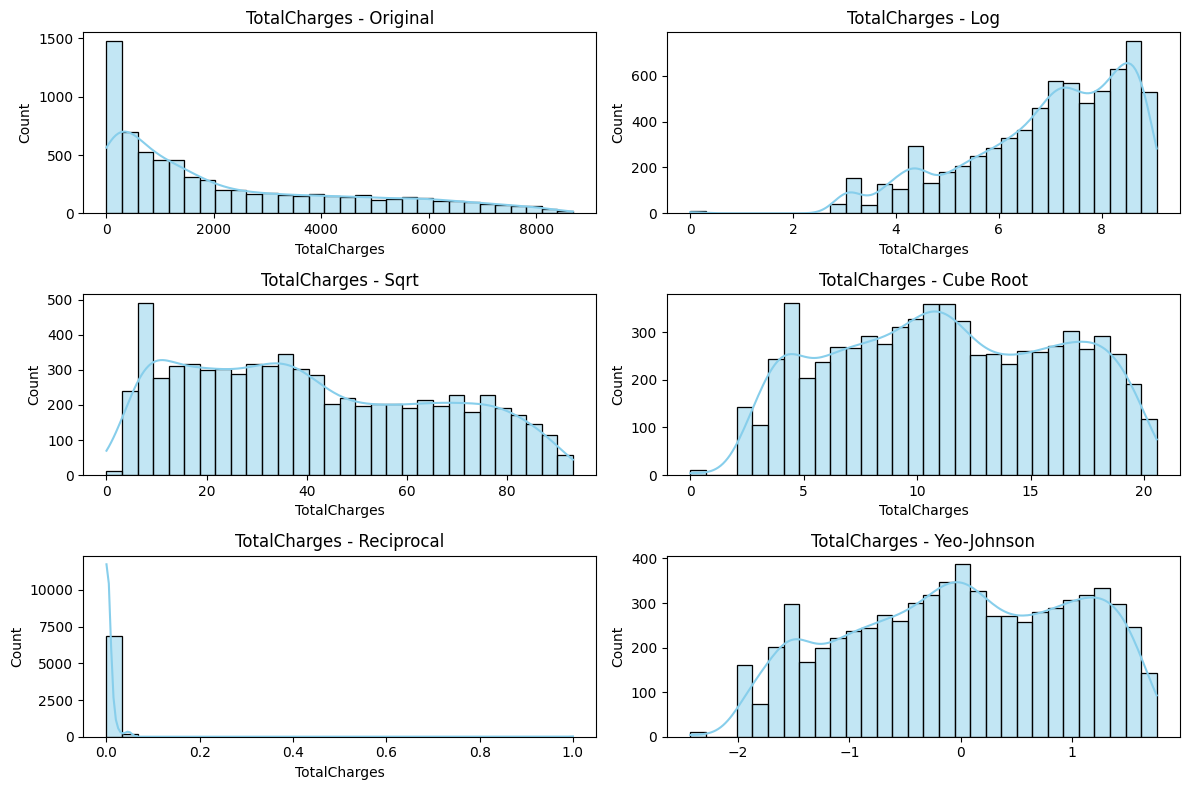

In [32]:
# Pick a numeric feature to test (example: TotalCharges)
feature = "TotalCharges"
x = df[feature].copy()

# Transformations
transforms = {
    "Original": x,
    "Log": np.log1p(x),
    "Sqrt": np.sqrt(x),
    "Cube Root": np.cbrt(x),
    "Reciprocal": 1/(x+1),  # +1 to avoid division by zero
    "Yeo-Johnson": PowerTransformer(method="yeo-johnson").fit_transform(x.values.reshape(-1,1)).flatten()
}

# Plot results
plt.figure(figsize=(12,8))
for i, (name, vals) in enumerate(transforms.items(), 1):
    plt.subplot(3,2,i)
    sns.histplot(vals, bins=30, kde=True, color="skyblue")
    plt.title(f"{feature} - {name}")
plt.tight_layout()
plt.show()


* Square root is better

# MonthlyCharges

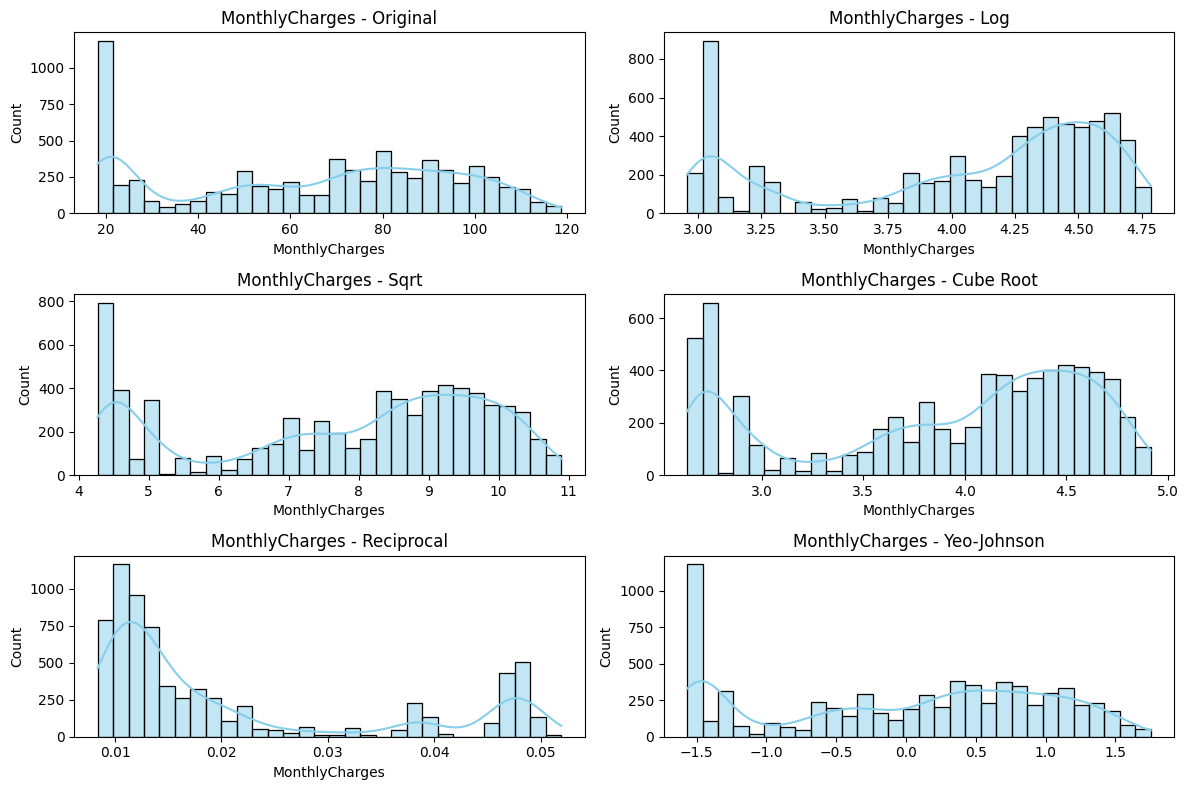

In [33]:
# Pick a numeric feature to test (example: TotalCharges)
feature = "MonthlyCharges"
x = df[feature].copy()

# Transformations
transforms = {
    "Original": x,
    "Log": np.log1p(x),
    "Sqrt": np.sqrt(x),
    "Cube Root": np.cbrt(x),
    "Reciprocal": 1/(x+1),  # +1 to avoid division by zero
    "Yeo-Johnson": PowerTransformer(method="yeo-johnson").fit_transform(x.values.reshape(-1,1)).flatten()
}

# Plot results
plt.figure(figsize=(12,8))
for i, (name, vals) in enumerate(transforms.items(), 1):
    plt.subplot(3,2,i)
    sns.histplot(vals, bins=30, kde=True, color="skyblue")
    plt.title(f"{feature} - {name}")
plt.tight_layout()
plt.show()


* No need to transform because each graph looks like the same

# tenture

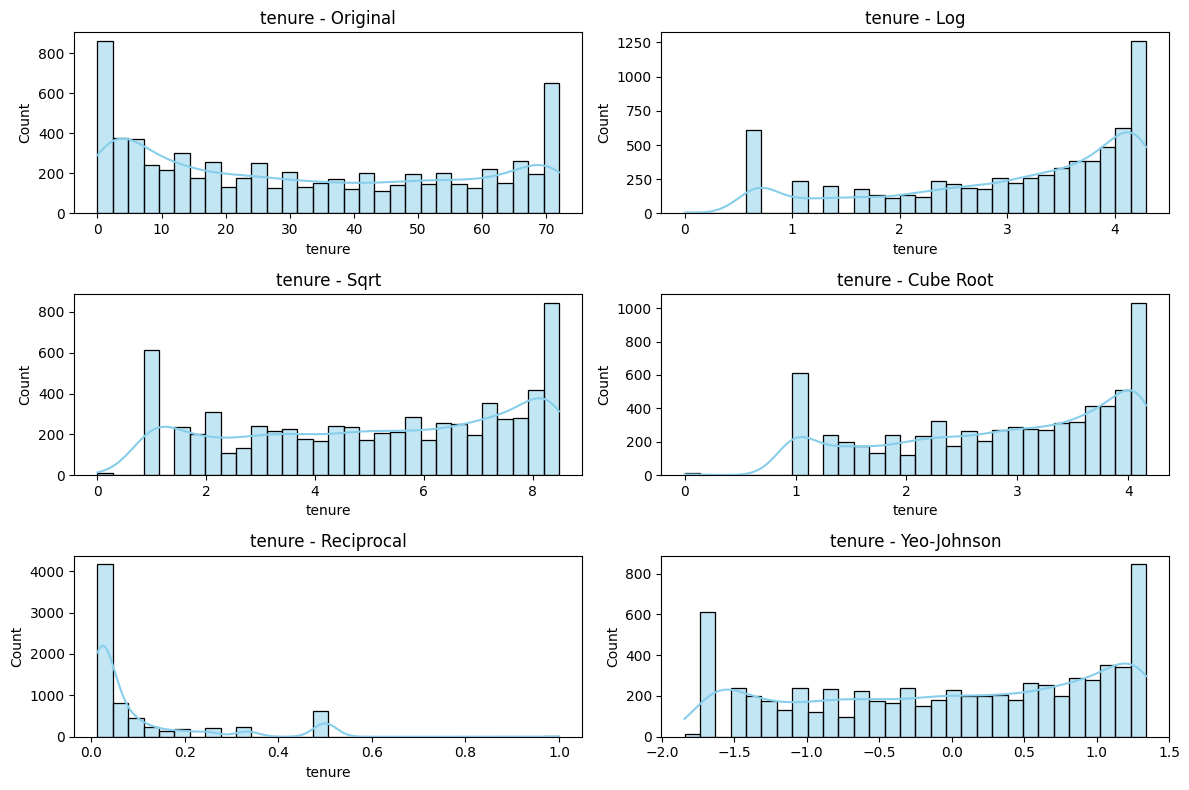

In [34]:
# Pick a numeric feature to test (example: TotalCharges)
feature = "tenure"
x = df[feature].copy()

# Transformations
transforms = {
    "Original": x,
    "Log": np.log1p(x),
    "Sqrt": np.sqrt(x),
    "Cube Root": np.cbrt(x),
    "Reciprocal": 1/(x+1),  # +1 to avoid division by zero
    "Yeo-Johnson": PowerTransformer(method="yeo-johnson").fit_transform(x.values.reshape(-1,1)).flatten()
}

# Plot results
plt.figure(figsize=(12,8))
for i, (name, vals) in enumerate(transforms.items(), 1):
    plt.subplot(3,2,i)
    sns.histplot(vals, bins=30, kde=True, color="skyblue")
    plt.title(f"{feature} - {name}")
plt.tight_layout()
plt.show()


* No need to transform

In [35]:
categorical_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'SeniorCitizen',
 'Charge_category',
 'Tenure_category',
 'Bundle_user']

In [36]:
# Define x and y
X = df.drop(["Churn"], axis = 1)
y = df["Churn"].map({
    "Yes":1,
    "No":0
})

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# Keep customerID from test set separately
customer_id = X_test["customerID"].copy()

# Drop customerID from features (train and test)
X_train = X_train.drop("customerID", axis=1)
X_test = X_test.drop("customerID", axis=1)

# Check shape
X_train.shape


(5634, 23)

# **Data Preprocessing Pipeline**

In [37]:
# Step 1: Apply sqrt to the selected column
sqrt_obj = FunctionTransformer(np.sqrt,validate = True)
sqrt_features = ['TotalCharges']

sqrt_transformer = ColumnTransformer(
    transformers=[
        ('sqrt',sqrt_obj,sqrt_features),
    ],
    remainder = 'passthrough'
)

# # Step 2: Scaling & normalization to all numeric columns
numeric_pipeline = Pipeline(
    steps=[
        ('sqrt_transform',sqrt_transformer),
        ('scaler',StandardScaler()),
    ]
)

# Step 3: Define objects for categorical columns
cat_features = [col for col in categorical_features if col != "Churn"]
norminal_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

# Step 4: Make the entire preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_pipeline,numerical_features),
        ('cat',norminal_encoder,cat_features)
    ]
)

# **Model Building Pipeline**

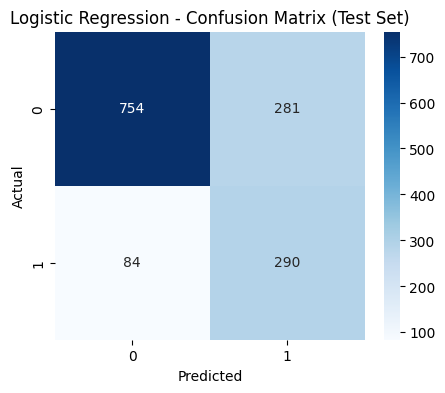


===== Logistic Regression =====
Training Accuracy : 0.754 | ROC-AUC : 0.851
Test Accuracy     : 0.741 | ROC-AUC : 0.841
Cross-Validation Accuracy : 0.750 ± 0.014
Cross-Validation ROC-AUC  : 0.847 ± 0.011
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



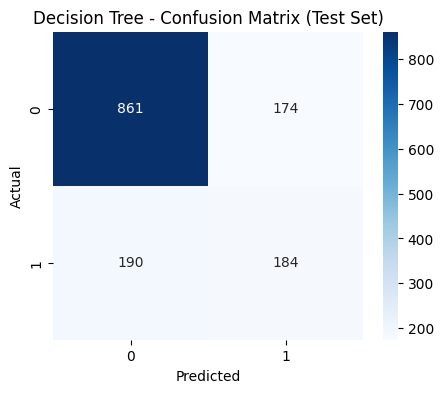


===== Decision Tree =====
Training Accuracy : 0.998 | ROC-AUC : 1.000
Test Accuracy     : 0.742 | ROC-AUC : 0.662
Cross-Validation Accuracy : 0.743 ± 0.012
Cross-Validation ROC-AUC  : 0.669 ± 0.017
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1035
           1       0.51      0.49      0.50       374

    accuracy                           0.74      1409
   macro avg       0.67      0.66      0.66      1409
weighted avg       0.74      0.74      0.74      1409



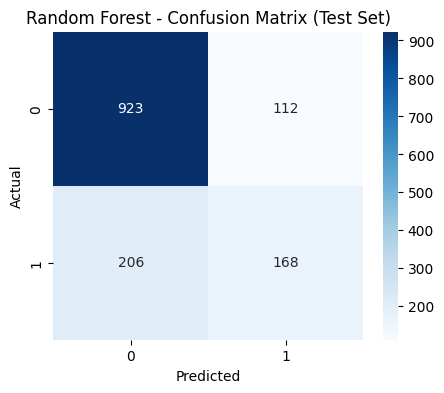


===== Random Forest =====
Training Accuracy : 0.998 | ROC-AUC : 1.000
Test Accuracy     : 0.774 | ROC-AUC : 0.821
Cross-Validation Accuracy : 0.786 ± 0.013
Cross-Validation ROC-AUC  : 0.818 ± 0.011
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1035
           1       0.60      0.45      0.51       374

    accuracy                           0.77      1409
   macro avg       0.71      0.67      0.68      1409
weighted avg       0.76      0.77      0.76      1409



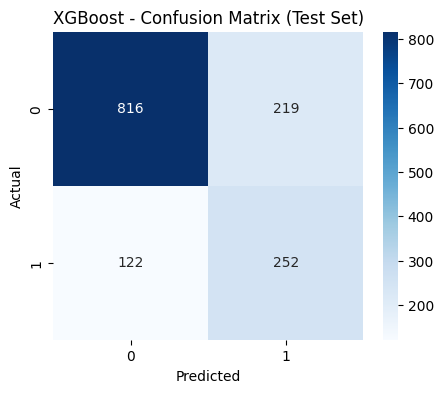


===== XGBoost =====
Training Accuracy : 0.931 | ROC-AUC : 0.988
Test Accuracy     : 0.758 | ROC-AUC : 0.822
Cross-Validation Accuracy : 0.775 ± 0.010
Cross-Validation ROC-AUC  : 0.825 ± 0.007
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1035
           1       0.54      0.67      0.60       374

    accuracy                           0.76      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.76      0.77      1409



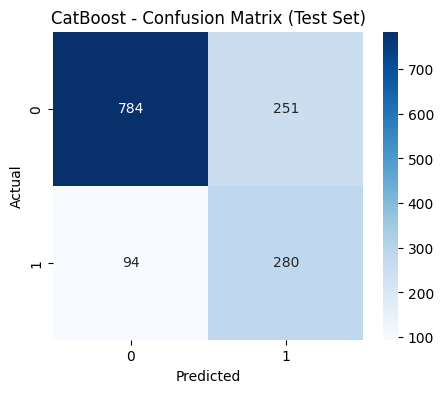


===== CatBoost =====
Training Accuracy : 0.852 | ROC-AUC : 0.941
Test Accuracy     : 0.755 | ROC-AUC : 0.838
Cross-Validation Accuracy : 0.767 ± 0.005
Cross-Validation ROC-AUC  : 0.842 ± 0.010
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409



In [38]:
# Suppose in training set:
n_positive = sum(y_train == 1)  # churned customers
n_negative = sum(y_train == 0)  # non-churned customers

scale_pos_weight = n_negative / n_positive
models = {
    "Logistic Regression": LogisticRegression(max_iter = 100,class_weight = 'balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight = 'balanced'),
    "Random Forest": RandomForestClassifier(n_estimators= 100,class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss',scale_pos_weight = (n_negative / n_positive)),
    "CatBoost":CatBoostClassifier(verbose=0,auto_class_weights='Balanced')
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    
    # --- Cross-validation on training data ---
    cv_scores = cross_validate(
        clf, X_train, y_train, cv=cv,
        scoring=["accuracy", "roc_auc"], return_train_score=True
    )
    
    # --- Fit on full training set ---
    clf.fit(X_train, y_train)
    
    # --- Predictions for training and test sets ---
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    y_train_proba = clf.predict_proba(X_train)[:,1]
    y_test_proba = clf.predict_proba(X_test)[:,1]
    
    # --- Metrics ---
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    # --- Confusion matrix (test set) ---
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.title(f"{name} - Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # --- Print metrics ---
    print(f"\n===== {name} =====")
    print(f"Training Accuracy : {train_acc:.3f} | ROC-AUC : {train_auc:.3f}")
    print(f"Test Accuracy     : {test_acc:.3f} | ROC-AUC : {test_auc:.3f}")
    print(f"Cross-Validation Accuracy : {cv_scores['test_accuracy'].mean():.3f} ± {cv_scores['test_accuracy'].std():.3f}")
    print(f"Cross-Validation ROC-AUC  : {cv_scores['test_roc_auc'].mean():.3f} ± {cv_scores['test_roc_auc'].std():.3f}")
    print(classification_report(y_test, y_test_pred))
    
    # --- Save results ---
    results[name] = {
        "train_accuracy": train_acc,
        "train_roc_auc": train_auc,
        "test_accuracy": test_acc,
        "test_roc_auc": test_auc,
        "cv_accuracy_mean": cv_scores['test_accuracy'].mean(),
        "cv_accuracy_std": cv_scores['test_accuracy'].std(),
        "cv_roc_auc_mean": cv_scores['test_roc_auc'].mean(),
        "cv_roc_auc_std": cv_scores['test_roc_auc'].std(),
        "confusion_matrix": cm
    }


**

**According to the above results Logistic Regression is the best model so far**

# **Hyperparameter tuning**

In [39]:
# Pipeline: preprocessing + model
clf_new = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    clf_new, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV ROC-AUC:", grid_search.best_score_)


Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best CV ROC-AUC: 0.8468832107586071


In [40]:
final_model = grid_search.best_estimator_
final_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('sqrt_transform',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('sqrt',
                                                                                                    FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                                                                        validate=True),
                                                                                                    ['TotalCharges'])])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'Service_count']),
                                                 ('cat',
                                                  OneHotEnc...
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen',
                                                   'Charge_category',
                                                   'Tenure_category',
                                                   'Bundle_user'])])),
                ('classifier', LogisticRegression(C=1, max_iter=1000))])

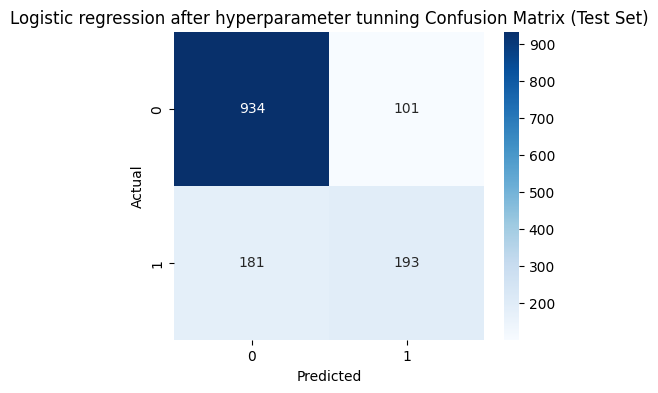


===== Logistic regression after hyperparameter tunning=====
Training Accuracy : 0.811 | ROC-AUC : 0.851
Test Accuracy     : 0.800 | ROC-AUC : 0.841
Cross-Validation Accuracy : 0.767 ± 0.005
Cross-Validation ROC-AUC  : 0.842 ± 0.010
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [41]:
# --- Fit on full training set ---
final_model.fit(X_train, y_train)

# --- Predictions for training and test sets ---
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

y_train_proba = final_model.predict_proba(X_train)[:,1]
y_test_proba = final_model.predict_proba(X_test)[:,1]

# --- Metrics ---
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# --- Confusion matrix (test set) ---
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.title("Logistic regression after hyperparameter tunning Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Print metrics ---
print("\n===== Logistic regression after hyperparameter tunning=====")
print(f"Training Accuracy : {train_acc:.3f} | ROC-AUC : {train_auc:.3f}")
print(f"Test Accuracy     : {test_acc:.3f} | ROC-AUC : {test_auc:.3f}")
print(f"Cross-Validation Accuracy : {cv_scores['test_accuracy'].mean():.3f} ± {cv_scores['test_accuracy'].std():.3f}")
print(f"Cross-Validation ROC-AUC  : {cv_scores['test_roc_auc'].mean():.3f} ± {cv_scores['test_roc_auc'].std():.3f}")
print(classification_report(y_test, y_test_pred))


# **Model Predictions**

In [42]:
# Predict for test data
test_preds = final_model.predict(X_test)

# Add predicted churn
predictions_df = X_test.copy()
predictions_df["Predicted Churn"] = test_preds
predictions_df["customerID"] = customer_id

# Reorder columns: customerID first
cols = ["customerID"] + [col for col in predictions_df.columns if col != "customerID"]
predictions_df = predictions_df[cols]

# View first few rows
predictions_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Tenure_category,Charge_category,Service_count,Bundle_user,Predicted Churn
437,4376-KFVRS,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Two year,Yes,Credit card (automatic),114.05,8468.20,Loyal,High,8,1,0
2280,2754-SDJRD,Female,1,No,No,8,Yes,Yes,Fiber optic,No,...,Month-to-month,Yes,Credit card (automatic),100.15,908.55,New,High,5,1,1
2235,9917-KWRBE,Female,0,Yes,Yes,41,Yes,Yes,DSL,Yes,...,One year,Yes,Credit card (automatic),78.35,3211.20,Established,Medium,6,1,0
4460,0365-GXEZS,Male,0,Yes,No,18,Yes,No,Fiber optic,No,...,Month-to-month,No,Electronic check,78.20,1468.75,Established,Medium,3,1,0
3761,9385-NXKDA,Female,0,Yes,No,72,Yes,Yes,DSL,Yes,...,Two year,Yes,Credit card (automatic),82.65,5919.35,Loyal,Medium,7,1,0


# **Conclusion**

In this project, we developed a robust machine learning pipeline to predict customer churn for a telecom company using the Telco Customer Churn dataset. The workflow covered data preprocessing, feature engineering, model training, evaluation, and prediction, ensuring a reproducible and production-ready pipeline.

**Key Steps and Insights**

* Data Preprocessing
* Handled numeric and categorical features separately.
* Applied a square root transformation to reduce skewness in TotalCharges.
* Standardized all numeric features using StandardScaler.
* Encoded categorical features with OneHotEncoder, ignoring unknown categories.
* Dropped irrelevant identifiers like customerID from the modeling features.
* Feature-Target Split and Data Splitting
* The target variable Churn was mapped to binary values (Yes=1, No=0).
* Stratified train-test split ensured balanced representation of classes in both sets.
* Modeling and Evaluation
* Multiple classification models were tested: Logistic Regression, Decision Tree, Random Forest, XGBoost, and CatBoost.
* Cross-validation was performed with stratification to obtain reliable performance estimates.
* Metrics evaluated included accuracy, ROC-AUC, and confusion matrices to capture both overall and class-level performance.

**Logistic Regression** emerged as the best-performing model of an 80% of test accuracy, achieving a high ROC-AUC and balanced accuracy, indicating both good predictive power and generalization.

**Hyperparameter Tuning**

* **GridSearchCV** was used to tune the regularization strength (C) of Logistic Regression.
* The final model combined preprocessing and tuned Logistic Regression in a single pipeline, ensuring that test data can be predicted without additional preprocessing.

**Predictions and Output**

* Predicted probabilities for the positive class (churn) were generated on the test set.
* A final DataFrame was created that retained all original features along with customerID and the predicted churn probability, ready for analysis or submission.

**Key Takeaways**

* Pipelines and ColumnTransformers ensure that preprocessing and modeling are fully reproducible and avoid data leakage.
* Cross-validation and ROC-AUC are essential for evaluating models on imbalanced datasets like churn prediction.
* Even simple models like Logistic Regression can perform strongly when proper preprocessing and hyperparameter tuning are applied.
* Feature engineering (e.g., sqrt transform for skewed data) significantly improves model stability and performance.

**Future Work / Improvements**

* Explore feature interactions or derived features for better predictive performance.
* Consider class imbalance handling using **SMOTE** if the churn ratio is highly skewed.
* Deploy the pipeline as a predictive service for real-time churn probability estimation.

Conclusion: The project demonstrates a complete end-to-end machine learning workflow. Logistic Regression, combined with thoughtful preprocessing and hyperparameter tuning, provides an effective solution for predicting telecom customer churn with interpretable and reproducible results.

